Hand classification using linear regression
===

In [11]:
# Imports
from IPython.display import Video
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time
import queue
import statistics
from tqdm import tqdm 
import pickle   # pip install pickle-mixin
import tensorflow as tf

## Preview video with frames
---

In [2]:
def preview_video(input_video_path: str, output_video_path: str):
    cap = cv2.VideoCapture(input_video_path)
    out = cv2.VideoWriter(output_video_path, -1, 20.0, (640,480))
    # get total number of frames
    totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    suc, prev = cap.read()
    prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    out.write(prevgray-prevgray)

    for image in range(int(totalFrames) - 1):

        suc, img = cap.read()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
        
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
        gray = cv2.dilate(gray,kernel,iterations = 2)
                
        fps = str(image) 
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        cv2.putText(gray, fps, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA)
        
        gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        
        out.write(gray_bgr)

        
    cap.release()
    out.release()
    
    
preview_video('gmm_fingers.mp4','gmm_fingers_frames.mp4')
Video('gmm_fingers_frames.mp4')

## Save images as resized data
---

In [3]:
cap = cv2.VideoCapture('gmm_fingers.mp4')

# get total number of frames
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

img_size = 128


suc, prev = cap.read()
prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

prevgray = cv2.resize(prevgray, (img_size,img_size))

images = np.zeros((int(totalFrames),np.shape(prevgray)[0],np.shape(prevgray)[1]),np.uint8)

images[0,:,:] = prevgray

for image in tqdm(range(int(totalFrames) - 1)):

    suc, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    gray = cv2.resize(gray, (img_size,img_size))
    
    images[image,:,:] = gray
    
    
cap.release()

100%|██████████| 613/613 [00:01<00:00, 378.73it/s]


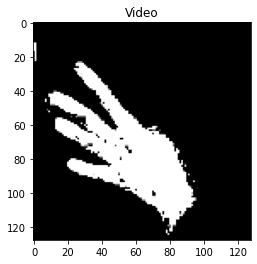

In [4]:
def show_img_in_notebook(frame):
    RGB_im = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    
    plt.imshow(RGB_im)
    plt.title("Video")
    plt.show()
    
show_img_in_notebook(images[100,:,:])

## Image Labeling
---

In [5]:
labels = np.zeros((int(totalFrames)),np.uint8)

labels[:] = 255
labels[:80] = 5
labels[100:145] = 4
labels[150:210] = 3
labels[220:280] = 2
labels[300:360] = 1
labels[370:420] = 0

## Remove unlabeled data
---

In [6]:
X_data = images

Y_lables = np.reshape(labels, (int(totalFrames),1))

X_data = X_data[Y_lables[:, -1] != 255]

Y_lables = Y_lables[Y_lables[:, -1] != 255]

X_data = (X_data-np.min(X_data))/(np.max(X_data)-np.min(X_data))


In [7]:
test = X_data[100,:,:]

## Split data and labels to train and test sets
---

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_lables, test_size=0.15, random_state=42)

number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]

x_train_flatten = x_train.reshape(number_of_train,x_train.shape[1]*x_train.shape[2])
x_test_flatten = x_test .reshape(number_of_test,x_test.shape[1]*x_test.shape[2])
print("X train flatten",x_train_flatten.shape)
print("X test flatten",x_test_flatten.shape)

# # Save data set
# with open('finger_dataset.pickle', 'wb') as output:
#     pickle.dump([X_data,Y_lables], output)

X train flatten (301, 16384)
X test flatten (54, 16384)


In [9]:
x_train = x_train_flatten
x_test = x_test_flatten
y_test = y_test.T
y_train = y_train.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (301, 16384)
x test:  (54, 16384)
y train:  (1, 301)
y test:  (1, 54)


## Augment images
---

In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)

epochs = 50


ValueError: Input to `.fit()` should have rank 4. Got array with shape: (301, 16384)

## Fit model
---

In [ ]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(datagen.flow(x_train, y_train, batch_size=32,
         subset='training'),
         validation_data=datagen.flow(x_train, y_train,
         batch_size=8, subset='validation'),
         steps_per_epoch=len(x_train) / 32, epochs=epochs)

#
y_pred=logreg.predict(x_test)

g:\My Drive\Repositories\Home Repositories\IMP_AR_project\.venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
g:\My Drive\Repositories\Home Repositories\IMP_AR_project\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## Create confusion matrix
---

In [ ]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[10,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0,  0],
       [ 0,  0,  8,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  4,  0],
       [ 0,  0,  0,  0,  0, 15]], dtype=int64)

In [ ]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

Text(0.5, 257.44, 'Predicted label')

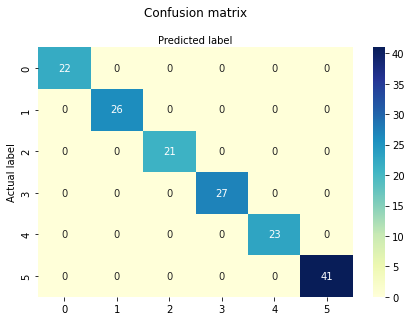

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Saving and loading model
---

In [ ]:
import pickle   # pip install pickle-mixin

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(logreg, open(filename, 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)



1.0


In [ ]:
def preview_pred_video(input_video_path: str, output_video_path: str):
    cap = cv2.VideoCapture(input_video_path)
    out = cv2.VideoWriter(output_video_path, -1, 20.0, (640,480))
    # get total number of frames
    totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    suc, prev = cap.read()
    prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    out.write(prevgray-prevgray)

    for image in range(int(totalFrames) - 1):

        suc, img = cap.read()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
        
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        gray_smaller = cv2.resize(gray, (img_size,img_size)).flatten()
        
        gray_smaller = np.reshape(gray_smaller,(1,img_size*img_size))
        
        y_pred=logreg.predict(gray_smaller)
        
        predict = str(y_pred)
        
        cv2.putText(gray, predict, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA)
        
        gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        
        out.write(gray_bgr)

        
    cap.release()
    out.release()
    
    
preview_pred_video('gmm_fingers.mp4','gmm_fingers_pred.mp4')
Video('gmm_fingers_pred.mp4')

## View on live
---

In [ ]:
# cap = cv2.VideoCapture(0)

cap = cv2.VideoCapture('http://192.168.0.169:4747/mjpegfeed?640x480')

# cap.set(cv2.CAP_PROP_BUFFERSIZE, 3)
# cap.set(CV_CAP_PROP_BUFFERSIZE, 3)

suc, prev = cap.read()
prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)


while True:

    suc, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
    prevgray = gray
    
    gray_smaller = cv2.resize(gray, (img_size,img_size)).flatten()
        
    gray_smaller = np.reshape(gray_smaller,(1,img_size*img_size))
    
    y_pred=logreg.predict(gray_smaller)
    
    predict = str(y_pred)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    cv2.putText(gray, predict, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA)
    
    gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    cv2.imshow('flow', gray_bgr)
    

    key = cv2.waitKey(5)
    if key == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()

In [21]:
num_classes = 10

from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()


11501568/11490434 [==============================] - 2s 0us/step


In [24]:
np.shape(x_train)[-3]

32

In [15]:
num_classes = 10

from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)



In [20]:
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation
from keras.regularizers import l2

#model construction
input_shape = np.shape(x_train)[1:]
output_dim = 10 # 3 possible outputs

def classification_model():
    model = Sequential()
    model.add(Dense(output_dim, input_shape=input_shape, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

#training
keras_model = classification_model()

# fits the model on batches with real-time data augmentation:
keras_model.fit(datagen.flow(x_train, y_train, batch_size=32,
         subset='training'),
         validation_data=datagen.flow(x_train, y_train,
         batch_size=8, subset='validation'),
         steps_per_epoch=len(x_train) / 32, epochs=500)

Epoch 1/500


ValueError: in user code:

    File "C:\Users\ophir\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\ophir\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ophir\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\ophir\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "C:\Users\ophir\AppData\Roaming\Python\Python39\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\ophir\AppData\Roaming\Python\Python39\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\ophir\AppData\Roaming\Python\Python39\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\ophir\AppData\Roaming\Python\Python39\site-packages\keras\losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\ophir\AppData\Roaming\Python\Python39\site-packages\keras\backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None) and (None, 32, 32, 10) are incompatible
